In [1]:
#loading a ton of packages we may or may not need

%load_ext autoreload
%autoreload 2
from nanoqnt.model.analyze_nanoqnt import AnalyzeNanoQNT

%aimport nanoqnt

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import scipy as sp
import scipy.optimize as opt
from nanoqnt.util import twoD_Gaussian
import skimage
import trackpy as tp
import seaborn as sns
from copy import copy
from scipy.spatial import KDTree

import pandas as pd
from matplotlib.ticker import StrMethodFormatter


In [2]:
base_folder = Path('/Users/ariellefrommer/Dispertech/Data/')
date = '2023-04-25'
data_folder = 'CD9-EGFP 1e7'

df_list = [] #list of data frames (the csv files) that we'll load into histograms

channel_num = 4

for i in range(channel_num):
    data_file = data_folder + f'_{i}.csv'
    file_path = base_folder / date / data_folder / data_file
    df_list.append(pd.read_csv(file_path))

plots_folder = Path('/Users/ariellefrommer/Dispertech/Plots')

'''

features to use for histograms/csv

df.head() - shows the beginning of the file, rows specified in ()
df.shape() - gives the rows/columns
df.describe - gives stats like count, mean, std, min/max, etc
df.types - gives different types of objects in the dataframe
df.loc() - can call parts of the dataframe (could use this to slice/grab portions of it)

'''

'\n\nfeatures to use for histograms/csv\n\ndf.head() - shows the beginning of the file, rows specified in ()\ndf.shape() - gives the rows/columns\ndf.describe - gives stats like count, mean, std, min/max, etc\ndf.types - gives different types of objects in the dataframe\ndf.loc() - can call parts of the dataframe (could use this to slice/grab portions of it)\n\n'

In [88]:
df_list[0].head(15)
print([len(df) for df in df_list])

[2850, 1701, 1110, 992]


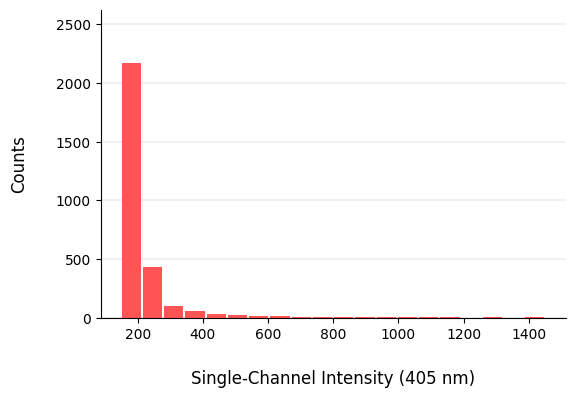

In [3]:
column = 'i_0'

ax = df_list[0].hist(column=column, bins=20, grid=False, figsize=(6,4), color='#ff5454', zorder=2, rwidth=.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(True)

    lines = x.get_yticks()
    for tick in lines:
        x.axhline(y=tick, linestyle='solid', alpha=0.8, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Single-Channel Intensity (405 nm)", labelpad=20, size=12) # can add weight=bold

    # Set y-axis label
    x.set_ylabel("Counts", labelpad=20, size=12)

plt.savefig(plots_folder/f'{data_folder}histogram_{column}.svg')


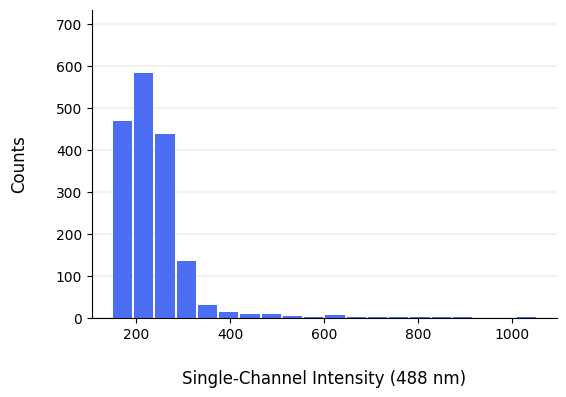

In [4]:
column = 'i_1'

ax = df_list[1].hist(column=column, bins=20, grid=False, figsize=(6,4), color='#4c6ef5', zorder=2, rwidth=.9)

ax = ax[0]
for x in ax:
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    
    lines = x.get_yticks()
    for tick in lines:
        x.axhline(y=tick, linestyle='solid', alpha=0.8, color='#eeeeee', zorder=1)

    x.set_title("")
    x.set_xlabel("Single-Channel Intensity (488 nm)", labelpad=20, size=12) # can add weight=bold
    x.set_ylabel("Counts", labelpad=20, size=12)
    
plt.savefig(plots_folder/f'{data_folder}histogram_{column}.svg')



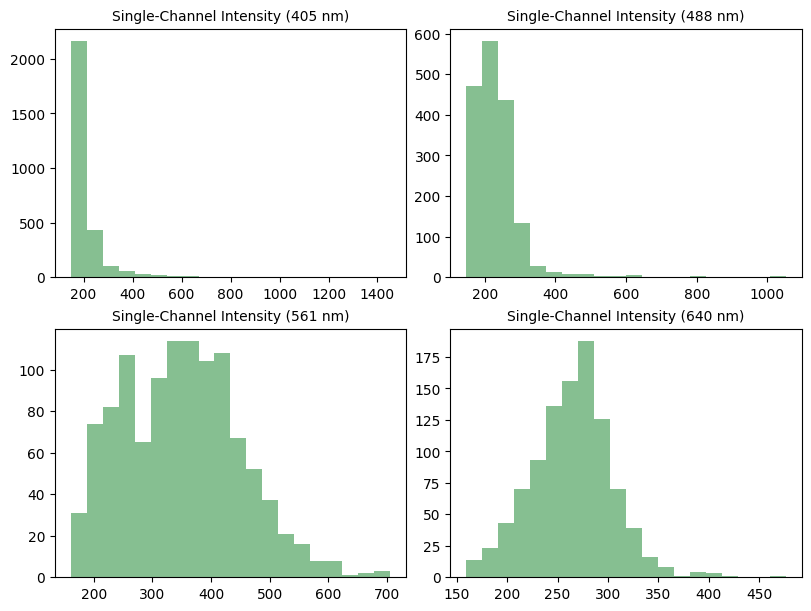

In [5]:
plt.figure(figsize=(8, 6), layout='constrained')
b,s = 20, 10
c = '#86bf91'
r = 1

plt.subplot(2, 2, 1)
plt.hist(df_list[0]['i_0'], bins=b, color=c, rwidth=r)
plt.title("Single-Channel Intensity (405 nm)", size=s)

if len(df_list) > 1:
    plt.subplot(2, 2, 2)
    plt.hist(df_list[1]['i_1'], bins=b, color=c, rwidth=r)
    plt.title("Single-Channel Intensity (488 nm)", size=s)

if len(df_list) > 2:
    plt.subplot(2, 2, 3)
    plt.hist(df_list[2]['i_2'], bins=b, color=c, rwidth=r)
    plt.title("Single-Channel Intensity (561 nm)", size=s)

if len(df_list) > 3:
    plt.subplot(2, 2, 4)
    plt.hist(df_list[3]['i_3'], bins=b, color=c, rwidth=r)
    plt.title("Single-Channel Intensity (640 nm)", size=s)
    
plt.savefig(plots_folder/f'{data_folder}histogram_subplot.svg')


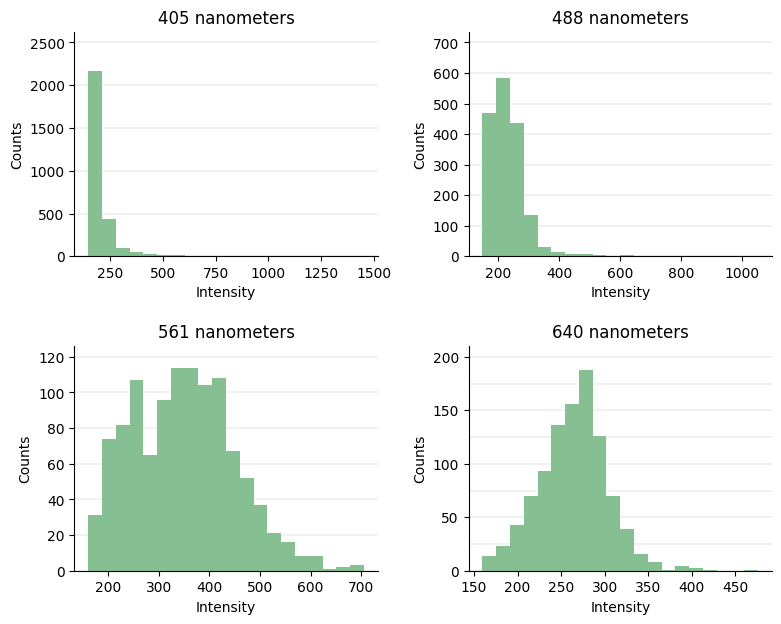

In [6]:
fig, axs = plt.subplots(2,2, figsize=(9, 7))
plt.subplots_adjust(wspace=0.3, hspace=0.4) #can also adjust top and bottom margins

bins = 20
title_sizes = 12
label_sizes = 10
color = '#86bf91' 
#this is green
#other colors - #86bf91 (blue), #fcdd4e (yellow), #ff5454 (red)

titles = ['405 nanometers', '488 nanometers', '561 nanometers', '640 nanometers'] #subject to change
x_axis = 'Intensity'
y_axis = 'Counts'

for i, ax in enumerate(axs.flat):
    ax.hist(df_list[i][f'i_{i}'], bins=bins, color=color, rwidth=1, zorder=2)
    
    #sets the title and labels
    ax.set_title(titles[i], size=title_sizes)
    ax.set_xlabel(x_axis, size=label_sizes)
    ax.set_ylabel(y_axis, size=label_sizes)
    
    #removes the top and right lines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    #adds the gray lines
    lines = ax.get_yticks()
    for tick in lines:
        ax.axhline(y=tick, linestyle='solid', alpha=0.8, color='#eeeeee', zorder=1)


plt.savefig(plots_folder/f'{data_folder}histogram_subplot.svg')


In [78]:
#defining functions and parameters

from math import isnan #used for removing nan values
from matplotlib.lines import Line2D #for the legend

#set parameters
title_size = 12
label_size = 10
marker = 'o'
alpha = 0.1
marker_size = 20

xmin, xmax = 100, 1600
ymin, ymax = 100, 1600

#prepare the color
c1 = '#86bf91'  # green
c2 = '#4c6ef5'  # blue
c3 = '#ff5454'  # red
colors = [c1, c2, c3]

#filtered_data stores 3 values in a tuple - the x value, y value, and color of each point
def nan_function(df_list, i, a, b, c, colors):
    data = []
    c1, c2, c3 = colors
    for  x1, x2, x3, y1, y2, y3 in zip(df_list[i][f'i_{i}'], df_list[i][f'i_{i}'], df_list[i][f'i_{i}'],
                                      df_list[i][f'i_{a}'], df_list[i][f'i_{b}'], df_list[i][f'i_{c}']):
        if not isnan(y1):
            data.append((x1, y1, c3))
        if not isnan(y2):
            data.append((x2, y2, c2))
        if not isnan(y3):
            data.append((x3, y3, c1))

    return data


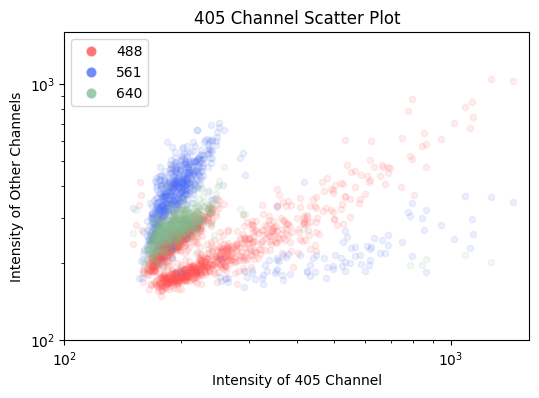

<Figure size 640x480 with 0 Axes>

In [72]:
from math import isnan #used for removing nan values
from matplotlib.lines import Line2D #for the legend

#set parameters
title_size = 12
label_size = 10
marker = 'o'
alpha = 0.1
marker_size = 20

xmin, xmax = 100, 1600
ymin, ymax = 100, 1600

c1 = '#86bf91'  # green
c2 = '#4c6ef5'  # blue
c3 = '#ff5454'  # red

#prepare the color and labels
zero_labels = ['488', '561', '640']
colors = [c3, c2, c1]
filtered_data = []

for i, color_label in enumerate(color_labels):
    color = colors[i]
    for x, y in zip(df_list[0]['i_0'], df_list[0][f'i_{i+1}']):
        if not isnan(y):
            filtered_data.append((x, y, color))
        
#scatter plot with filtered data
fig, ax = plt.subplots(1, figsize=(6, 4))
for x, y, color in filtered_data:
    ax.scatter(x, y, marker=marker, alpha=alpha, s=marker_size, color=color)

ax.set_title('405 Channel Scatter Plot', size=title_size)

#set x and y axes
ax.set_xlabel('Intensity of 405 Channel', size=label_size)
ax.set_ylabel('Intensity of Other Channels', size=label_size)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yscale('log')
ax.set_xscale('log')

#adjust tick label size
ax.tick_params(labelsize=label_size)

# Add a legend
legend_handles = [Line2D([0], [0], marker=marker, color='w', markerfacecolor=color, markersize=8, alpha=0.8, label=label) 
                  for color, label in zip(colors, zero_labels)]

ax.legend(handles=legend_handles, loc='upper left', fontsize=10)

plt.show() 
plt.savefig(plots_folder / f'{data_folder}_multicolor_scatter_plot_405.svg')


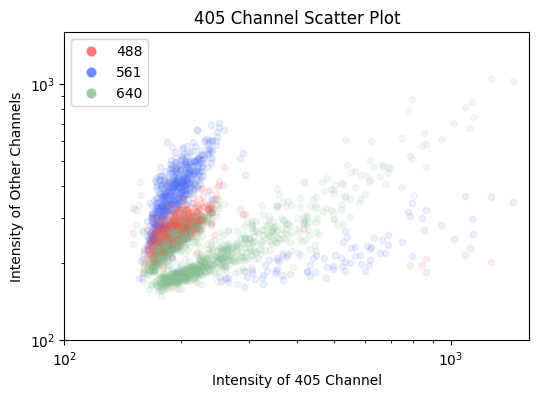

<Figure size 640x480 with 0 Axes>

In [73]:
#creating the scatterplot data
data_405 = nan_function(df_list, 0, 1, 2, 3, colors)

#scatterplot
fig, ax = plt.subplots(1, figsize=(6, 4))
for x, y, color in data_405:
    ax.scatter(x, y, marker=marker, alpha=alpha, s=marker_size, color=color)

ax.set_title('405 Channel Scatter Plot', size=title_size)

#set x and y axes
ax.set_xlabel('Intensity of 405 Channel', size=label_size)
ax.set_ylabel('Intensity of Other Channels', size=label_size)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yscale('log')
ax.set_xscale('log')

#adjust tick label size
ax.tick_params(labelsize=label_size)

# Add a legend
legend_handles = [Line2D([0], [0], marker=marker, color='w', markerfacecolor=color, markersize=8, alpha=0.8, label=label) 
                  for color, label in zip(colors, zero_labels)]

ax.legend(handles=legend_handles, loc='upper left', fontsize=10)

plt.show() 
plt.savefig(plots_folder / f'{data_folder}_multicolor_scatter_plot_405.svg')

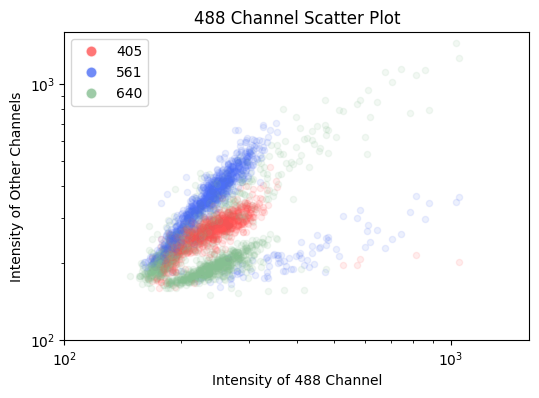

<Figure size 640x480 with 0 Axes>

In [74]:
#creating the scatterplot data
data_488 = nan_function(df_list, 1, 0, 2, 3, colors)

#scatterplot
fig, ax = plt.subplots(1, figsize=(6, 4))
for x, y, color in data_488:
    ax.scatter(x, y, marker=marker, alpha=alpha, s=marker_size, color=color)

ax.set_title('488 Channel Scatter Plot', size=title_size)

#set x and y axes
ax.set_xlabel('Intensity of 488 Channel', size=label_size)
ax.set_ylabel('Intensity of Other Channels', size=label_size)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yscale('log')
ax.set_xscale('log')

#adjust tick label size
ax.tick_params(labelsize=label_size)

# Add a legend
legend_handles = [
    Line2D([0], [0], marker=marker, color='w', markerfacecolor=c3, markersize=8, alpha=0.8, label='405'),
    Line2D([0], [0], marker=marker, color='w', markerfacecolor=c2, markersize=8, alpha=0.8, label='561'),
    Line2D([0], [0], marker=marker, color='w', markerfacecolor=c1, markersize=8, alpha=0.8, label='640')
]

ax.legend(handles=legend_handles, loc='upper left', fontsize=10)

plt.show() 
plt.savefig(plots_folder / f'{data_folder}_multicolor_scatter_plot_488.svg')



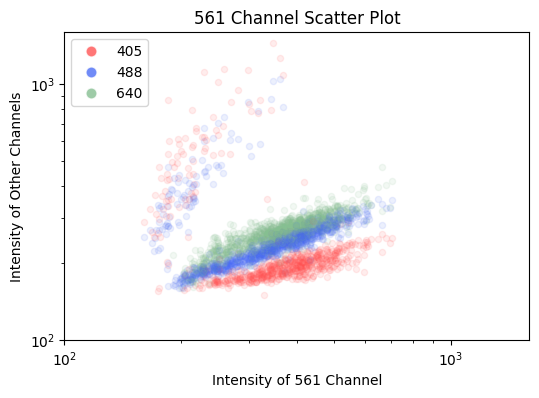

<Figure size 640x480 with 0 Axes>

In [76]:
#creating the scatterplot data
data_561 = nan_function(df_list, 2, 0, 1, 3, colors)

#scatterplot
fig, ax = plt.subplots(1, figsize=(6, 4))
for x, y, color in data_561:
    ax.scatter(x, y, marker=marker, alpha=alpha, s=marker_size, color=color)

ax.set_title('561 Channel Scatter Plot', size=title_size)

#set x and y axes
ax.set_xlabel('Intensity of 561 Channel', size=label_size)
ax.set_ylabel('Intensity of Other Channels', size=label_size)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yscale('log')
ax.set_xscale('log')

#adjust tick label size
ax.tick_params(labelsize=label_size)

# Add a legend
legend_handles = [
    Line2D([0], [0], marker=marker, color='w', markerfacecolor=c3, markersize=8, alpha=0.8, label='405'),
    Line2D([0], [0], marker=marker, color='w', markerfacecolor=c2, markersize=8, alpha=0.8, label='488'),
    Line2D([0], [0], marker=marker, color='w', markerfacecolor=c1, markersize=8, alpha=0.8, label='640')
]

ax.legend(handles=legend_handles, loc='upper left', fontsize=10)

plt.show() 
plt.savefig(plots_folder / f'{data_folder}_multicolor_scatter_plot_561.svg')




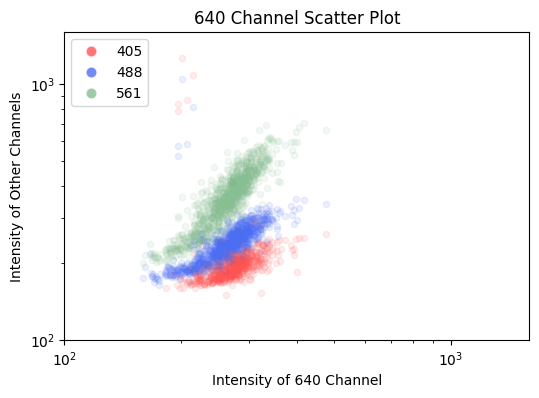

<Figure size 640x480 with 0 Axes>

In [89]:
#creating the scatterplot data
data_640 = nan_function(df_list, 3, 0, 1, 2, colors)

#scatterplot
fig, ax = plt.subplots(1, figsize=(6, 4))
for x, y, color in data_640:
    ax.scatter(x, y, marker=marker, alpha=alpha, s=marker_size, color=color)

ax.set_title('640 Channel Scatter Plot', size=title_size)

#set x and y axes
ax.set_xlabel('Intensity of 640 Channel', size=label_size)
ax.set_ylabel('Intensity of Other Channels', size=label_size)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yscale('log')
ax.set_xscale('log')

#adjust tick label size
ax.tick_params(labelsize=label_size)

# Add a legend
legend_handles = [
    Line2D([0], [0], marker=marker, color='w', markerfacecolor=c3, markersize=8, alpha=0.8, label='405'),
    Line2D([0], [0], marker=marker, color='w', markerfacecolor=c2, markersize=8, alpha=0.8, label='488'),
    Line2D([0], [0], marker=marker, color='w', markerfacecolor=c1, markersize=8, alpha=0.8, label='561')
]

ax.legend(handles=legend_handles, loc='upper left', fontsize=10)

plt.show() 
plt.savefig(plots_folder / f'{data_folder}_multicolor_scatter_plot_640.svg')


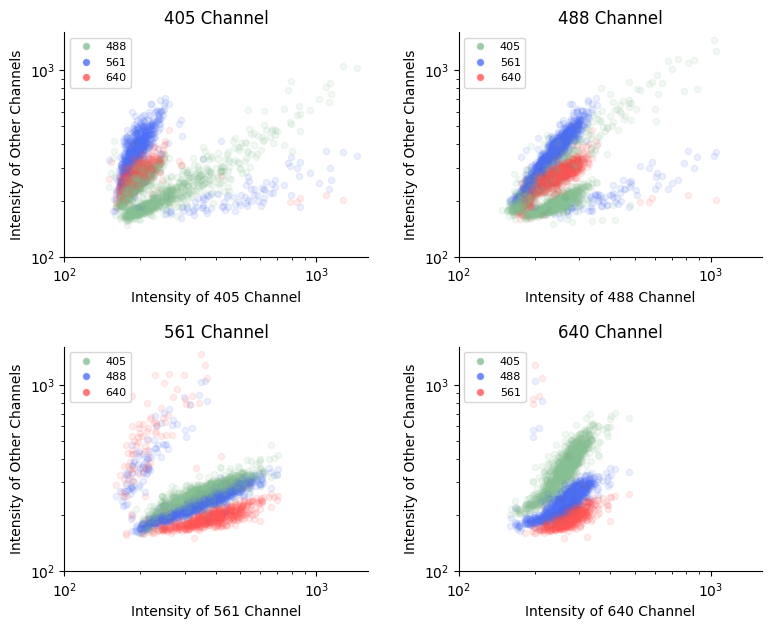

<Figure size 640x480 with 0 Axes>

In [84]:
fig, axs = plt.subplots(2,2, figsize=(9, 7))
plt.subplots_adjust(wspace=0.3, hspace=0.4) #can also adjust top and bottom margins

all_data = [data_405, data_488, data_561, data_640]
titles = ['405 Channel', '488 Channel', '561 Channel', '640 Channel'] #subject to change
x_axis = ['Intensity of 405 Channel', 'Intensity of 488 Channel', 
'Intensity of 561 Channel', 'Intensity of 640 Channel']
y_axis = 'Intensity of Other Channels'
color_labels = [['488', '561', '640'], ['405', '561', '640'], ['405', '488', '640'], ['405', '488', '561']]

for i, ax in enumerate(axs.flat):
    for x, y, color in all_data[i]:
        ax.scatter(x, y, marker=marker, alpha=alpha, s=marker_size, color=color)
    
    #sets the title and labels
    ax.set_title(titles[i], size=title_size)
    ax.set_xlabel(x_axis[i], size=label_size)
    ax.set_ylabel(y_axis, size=label_size)

    #removes the top and right lines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #sets the scale and limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_yscale('log')
    ax.set_xscale('log')

    #adjust tick label size
    ax.tick_params(labelsize=label_size)
    
    #legend handles and labels for the scatter plot
    legend_handles = []
    legend_labels = []
    for color, label in zip(colors, color_labels[i]):
        legend_handles.append(Line2D([0], [0], marker=marker, color='w', markerfacecolor=color, markersize=6, alpha=0.8))
        legend_labels.append(label)
    
    #add legend to the scatter plot
    ax.legend(legend_handles, legend_labels, loc='upper left', fontsize=8)

plt.show() 

plt.savefig(plots_folder/f'{data_folder}scatter_subplot.svg')

In [ ]:
#potentially write a function for the legend

#think about how to abstract this even further / incorporate into the software...

#looking at software, k-means clustering, parsing channel names from text file
